In [1]:
# Program for finding the shape of the lipid bilayer with the initial direction of the director

from time import time 
import scipy.optimize
import numpy as np
import matplotlib
import pandas as pd
import csv
from google.colab import drive
import os
import sys

In [2]:
''' Эта функция отвечает за переход в нужную деректорию и выбора номера с которым будут сохраняться файлы. '''

def connection():
  drive.mount('/content/gdrive')
  os.chdir('/content/gdrive/My Drive/Data')



''' Определяет номер элемента списка перед началом числа или списка из них. '''

def define_start (unknown_list):

  number = None
  n = 0

  for i in unknown_list :
  
    if type(i) == list or type(i) == tuple:
        
      for j in i:

        try:
          float(j)
          break

        except:
          number = n

    else:

      try:
        float(i)

      except:
        number = n

    n += 1

  return number



''' Эта функция переводит все численные значения в списке или в кортеже (может быть однокртано вложенным) в строковый формат.'''

def convert_to_str (unknown_list):

# Нужно для того, чтобы избежать изменения входных данных списка, либо для создания списка из кортежа
  data = list(unknown_list)

  for i in range( len(data) ):

    if type( data[i] ) == list: 

      for j in range( len(data[i]) ):

        if data[i][j] != None:        
          data[i][j] = str(data[i][j])

        else:
          data[i][j] = 'None'
    else:
      if data[i] != None:
        data[i] = str(data[i])

      else:
        data[i] = 'None'

  return data



''' Эта функция определяет файл в директории Data с самым большим номером и вычисляет 
индекс для сохранения файлов. '''

def define_number ():

  comparator = 0
  counter = 0

# Прохождение по всем файлам дериктории
  for file in os.listdir(os.getcwd()):
    j = len(file) - 1 
    l = None
    f = None
    counter = 0

    for i in range(j + 1):

      if i == '_':
        counter += 1
    
    if counter == 2:
      symbol = '_'

    else:
      symbol = '.'

    while j > 3:

      if file[j] == symbol:
        l = j

      if l != None:

        try:
          int( file[j - 1] )
            
        except:
          f = j
          break

      j -= 1

# Нужно как для избежания нулегого значения, так и для избежания присвоения номера для пустой директории.
# Срез вектора с одинаковым началом концом выдает пустой список.

    if counter != 0:

      if f == l:
        iterable = int( file[f] )
    
      else:
        iterable = int( file[f:l] )

      if comparator < iterable:
        comparator = iterable

  if counter == 0:
    return None
  
  else:
    return comparator + 1



''' Функция для постройки графиков. Принимает список в диапазоне от 1 до 4 элементов в 
формате строки, соотвествующих обозначениям парметров. В случае возникновения ошибки
TypeError обратить внимание на то, какие элементы содеражаться в списке. '''

def graph ( data, functions = ['n_u'], number = None ):

  number_funs = len( functions )
  Y = []

  for fun in functions:

    point_fun_txt = f'point.{fun}'
    y = [eval(point_fun_txt) for point in data]
    
    Y.append(y)

  X = [ point.r for point in data]

  if number_funs == 1:

      matplotlib.pyplot.plot( X, Y[0] )
      matplotlib.pyplot.xlabel( 'r, нМ' )
      matplotlib.pyplot.ylabel( str( functions[0] ) + ', нМ' )

  else:
    
    for i in range(number_funs):

      matplotlib.pyplot.plot( X, Y[i] )     
      matplotlib.pyplot.xlabel('r, нМ')
      matplotlib.pyplot.ylabel('z, нМ' )

  if number == None:
    matplotlib.pyplot.grid()
    matplotlib.pyplot.show()

  else:

    if f'graph_{number}_.svg' in os.listdir(os.getcwd()):
      i = 0

      while f'graph_{number}_{i}.svg' in os.listdir(os.getcwd()):
        i += 1
    matplotlib.pyplot.grid()
    matplotlib.pyplot.savefig(f'graph_{number}_{i}.svg')


''' This class is used to define each point of grid '''

class point:

  def __init__( self, r, n_u, n_d, H_u, H_d, M ):
    self.r = r
    self.n_u = n_u
    self.n_d = n_d
    self.H_u = H_u
    self.H_d = H_d
    self.M = M

  def __repr__(self):
    return "Point({0.r!r}, {0.n_u!r}, {0.n_d!r}, {0.H_u!r}, {0.H_d!r}, {0.M!r})".format(self)

  def __str__(self):
    return "({0.r!r}, {0.n_u!r}, {0.n_d!r}, {0.H_u!r}, {0.H_d!r}, {0.M!r})".format(self)



''' Функция энергии данная в виде ряда. Важно заметить, что отпущен множитель np.pi. '''

def energy ( x, ir, parameters, left_values, right_values):
  
# Присвоение начальных параметров бислоя.
  (sigma, Kt, Ka, B, h_0u, h_0d, J_0u, J_0d) = parameters
  (n_0u, n_0d, H_0u, H_0d, M_0) = left_values
  (n_1u, n_1d, H_1u, H_1d, M_1) = right_values

  # Индекс i перед параметром, говорит, о том, что это начальная перменная. Хочу заметить, что
  # из-за операции конкатеции векторы получаются на один больше. Было решено это учесть в 
  # Объявлении начальных значений. Вектор ir на 5 больше.

  in_u, in_d = x[::5], x[1::5]
  iH_u, iH_d, iM = x[2::5], x[3::5], x[4::5]

  # Подставляем граничные условия, если только в них не записан None
  if n_0u != None: in_u[0] = n_0u
  if n_1u != None: in_u[-1] = n_1u
  if n_0d != None: in_d[0] = n_0d
  if n_1d != None: in_d[-1] = n_1d
  if H_0u != None: iH_u[0] = H_0u
  if H_1u != None: iH_u[-1] = H_1u 
  if H_0d != None: iH_d[0] = H_0d
  if H_1d != None: iH_d[-1] = H_1d
  if M_0 != None: iM[0] = M_0
  if M_1 != None: iM[-1] = M_1

# Обрезка веторов для того, чтобы они стали равны веторам производных и дифференциалов
  n_u = in_u[: -1]
  n_d = in_d[: -1]
  H_u = iH_u[: -1]
  H_d = iH_d[: -1]
  M = iM[: -1]
  r = ir[: -1]
  
# Определение дифференциалов и производных
  dr = ir[1:] - ir[:-1]
  dn_u = (in_u[1:] - in_u[:-1])/dr
  dn_d = (in_d[1:] - in_d[:-1])/dr
  dH_u = (iH_u[1:] - iH_u[:-1])/dr
  dH_d = (iH_d[1:] - iH_d[:-1])/dr
  
  en_B_u = ((dn_u + n_u/r + J_0u)**2 - J_0u**2)
  en_B_d = ((dn_d + n_d/r + J_0d)**2 - J_0d**2)
  en_Kt_u = ((n_u - dH_u)**2)
  en_Kt_d = ((n_d + dH_d)**2)
  en_Ka_u = ((1 - (H_u - M)/h_0u - h_0u*(dn_u + n_u/r)/2)**2)
  en_Ka_d = ((1 - (M - H_d)/h_0d - h_0d*(dn_d + n_d/r)/2)**2)
  en_sigma_u = (dH_u**2)
  en_sigma_d = (dH_d**2)

  en = np.sum( ( B* (en_B_u + en_B_d) + Kt* (en_Kt_u + en_Kt_d) + Ka* (en_Ka_u + en_Ka_d) + sigma*( en_sigma_u + en_sigma_d ) ) *r *dr )

  return en



''' Функция предназначенная для лучшей визуализаиции. Переводит полученные данные в класс grid. '''

def mk_grid ( results, r, left_values = None, right_values = None):

  output = list()

  N_points = len(results)//5

  for i in range(N_points - 1 ):
    output.append( point( r = r[i] , n_u = results[i*5], n_d = results[i*5 + 1], H_u = results[i*5 + 2], H_d = results[i*5 + 3], M = results[i*5 + 4] ) )

  return output



''' Сохраняет раузльтаты в формате csv. '''

def save_grid ( grid, number, energy_res = None, left_values = None, right_values = None ):

  if left_values != None:
    str_left_values = convert_to_str(left_values)

  if right_values != None:  
    str_right_values = convert_to_str(right_values)

# Создание шапки файла
  if left_values != None or right_values != None:
    header = [['', '', '', 'Results', '', '', '', '', '', '', '', '', 'Init values']]
    if energy_res != None:
      header.append(['numb','r','n_u','n_d','H_u','H_d','M','Energy'])
    else:
      header.append(['numb','r','n_u','n_d','H_u','H_d','M'])
    if left_values != None:
      header[1] += ['n_0u', 'n_0d', 'H_0u', 'H_0d', 'M_0']
    if right_values != None:
      header[1] += ['n_1u', 'n_1d', 'H_1u', 'H_1d', 'M_1']

  else:
    if energy_res != None:
      header = ['numb','r','n_u','n_d','H_u','H_d','M','Energy']

    else:
      header = ['numb','r','n_u','n_d','H_u','H_d','M']

  data = []
  i = 0

# Cоздание вложенного списка из строковых данных, которые в последующем будут сохранены
  for dot in grid:
    data.append([str(i), str(dot.r), str(dot.n_u), str(dot.n_d), str(dot.H_u), str(dot.H_d),str(dot.M)])

    if i == 0:

      if energy_res != None:
        data[0].append( str(energy_res) )

      if left_values != None:
        data[0] += str_left_values

      if right_values != None:
        data[0] += str_right_values

    i += 1

# Создание файла и запись данных
  with open(f'grid_{number}.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    if left_values != None or right_values != None:
      writer.writerows(header)

    else:
      writer.writerow(header)

    writer.writerows(data)
 


''' Считывает рузльтаты из файла csv выдавая в  результате либо список из элементов
класса point, либо из энергии левых и правых краевых значений, а также список из элементов класса point'''

def load_grid ( file_name, exceptions = 'numb' ):

  point_variables = ('r','n_u','n_d','H_u','H_d','M')
  left_variables = ('n_0u', 'n_0d', 'H_0u', 'H_0d', 'M_0')
  right_variables = ('n_1u', 'n_1d', 'H_1u', 'H_1d', 'M_1')
  left_values = []
  right_values = []
  energy_value = None

# Открытие файла для чтения с переносом данных в список content
  with open(file_name, newline='') as csvfile:
    array = csv.reader(csvfile, delimiter=';' )
    content=[]
    for row in array:
      if len( row ) > 0:
        content.append( row[0].split(',') )

# Определение последней строки с str элементами.
  j = define_start( content )

# Присвоение первой строки файла переменной header, которая будет отвечать за присвоение значений классу point
  header = content[j]
  grid = list()
  major_part =  content[j+1:]

# Прохождение по строкам файла 
  for n in range( len( major_part ) ):
    dot = str()

# Прохождения по элементам строки (столбцам)
    for i in range( len( major_part[n] ) ):

# Проверка на наличие краевых условий, либо значения энергии
      if n == 0:

        if header[i] in left_variables:

          if major_part[n][i] == 'None':
            left_values.append( None )

          else:
            left_values.append( float( major_part[n][i] ) )
        
        elif header[i] in right_variables:

          if major_part[n][i] == 'None':
            right_values.append( None )

          else:
            right_values.append( float( major_part[n][i] ) )

        elif header[i] == 'Energy':
          energy_value = float(major_part[n][i])

# Создание строки с реультатами для одного элемента класса point      
      if header[i] in point_variables:
        dot += f'{header[i]} = {major_part[n][i]},'

    dot = dot[:-1]
    exec_code = f'point({dot})'
    grid.append( eval( exec_code )  )

  if len(left_values) == 0 and len(right_values) == 0 and energy_value == None:
    return grid

# Проверка на наличие кревых условий или вычесленной энергии
  else:
    output = [grid]

    if energy_value != None:
      output.append(energy_value)
    
    if len(left_values) != 0:
      output.append(left_values)

    if len(right_values) != 0:
      output.append(right_values)

    return output

In [3]:
connection()

Mounted at /content/gdrive


In [ ]:
%%time

# Чтение параметров из таблицы с данными.

length = 89
N = 200
est_H_0u, est_H_0d = 1.6, -1.6
#parameters = (sigma,  Kt,  Ka,  B,  h_0u,  h_0d, J_0u, J_0d)
parameters =  (0.3,  10.,  30.,  10.,  1.6,  1.6,  0.1,  -0.16)

x0 = ((np.array([np.linspace(0.0, 0, num = N-1), np.linspace(0.0, 0, num = N-1),\
np.linspace(est_H_0u, est_H_0u, num = N-1), np.linspace(est_H_0d, est_H_0d, num = N-1), np.linspace(0, 0, num = N-1)])).transpose()).ravel()
x0 = np.concatenate(([0, 0, est_H_0u, est_H_0d, 0], x0, [0, 0, est_H_0u, est_H_0d, 0]))

reference_data = pd.read_csv('/content/gdrive/My Drive/additional_files/data_comparison.csv')
s = pd.Series([None for i in range(length)], index = [i for i in range(length)])
reference_data['num_en'] = s.values
reference_data['en_dif'] = s.values
reference_data['mod_en'] = s.values

#number_samples = [i for i in range(length)]

number_samples = [9,16,36,48,64,74]

for row_number in number_samples:

  # Импорт данных из файла
  r_start = reference_data['r_start'][row_number]
  r_fin = reference_data['r_fin'][row_number]
  n_0u = reference_data['n_0u'][row_number]
  n_0d = reference_data['n_0d'][row_number]
  n_1u = reference_data['n_1u'][row_number]
  H_0u = reference_data['H_0u'][row_number]
  ref_en = reference_data['en'][row_number]
  
  # Задание начальных парметров

  #left_values = (n_0u, n_0d, H_0u, H_0d, M_0)
  left_values =  (n_0u, n_0d, H_0u, None, None)
  right_values = (n_1u, None, None, None, None)

  r = np.linspace(r_start, r_fin, num = N+1)

  res = scipy.optimize.minimize( energy, x0, args = (r, parameters, left_values, right_values), tol = 10^(-5))
  x_min = res.x
  en = np.pi*energy(x_min, r, parameters, left_values, right_values)
  out = mk_grid(res.x, r, left_values, right_values)
  data_number = row_number

  # Сохранение файлов в папку data
  graph( out, ['n_u','n_d'], data_number )
  graph( out, ['H_u','H_d', 'M'], data_number )
  save_grid( out, data_number, en, left_values, right_values)
  
  # Добавление вычсиленных энергий и разницы поделенной на модуль в исходный csv файл.
  en_dif = ref_en - en
  mod_en = en_dif / abs(en)
  reference_data.at[row_number,'num_en'] = en
  reference_data.at[row_number,'en_dif'] = en_dif
  reference_data.at[row_number,'mod_en'] = mod_en

reference_data.to_csv('/content/gdrive/My Drive/additional_files/data_comparison_3.csv', index=False)

In [4]:
# Определение начальных значений.

N = 50
r_start = 0.6
r_fin = 4
r = np.linspace(r_start, r_fin, num = N+1)
est_H_0u, est_H_0d = 1.4, -1.4
# стартовые значения
x0 = ((np.array([np.linspace(0.0, 0, num = N-1), np.linspace(0.0, 0, num = N-1),\
np.linspace(est_H_0u, est_H_0u, num = N-1), np.linspace(est_H_0d, est_H_0d, num = N-1), np.linspace(0, 0, num = N-1)])).transpose()).ravel()
# добиваем справа и слева, чтобы можно было подставить гранусловия, если надо
x0 = np.concatenate(([0, 0, est_H_0u, est_H_0d, 0], x0, [0, 0, est_H_0u, est_H_0d, 0]))

#parameters = (sigma, Kt,  Ka, B, h_0u, h_0d, J_0u, J_0d)
parameters =  (0.1,  10.,  30.,  10., 1.6,  1.6,  0.0,  0.0)
#left_values = (n_0u, n_0d, H_0u, H_0d, M_0)
left_values = (0.2, 0.1, 1.2, -1.2, 0.1)
right_values = (0.3, 0.4, 1.7, -1.9, 0.3)


In [5]:
%%time
res = scipy.optimize.minimize( energy, x0, args = (r, parameters, left_values, right_values), tol = 10^(-5))
x_min = res.x

en = np.pi*energy(x_min, r, parameters, left_values, right_values)
print(f'Energy = {en}')

out = mk_grid(res.x, r, left_values, right_values)

Energy = 27.90534094072839
CPU times: user 10.8 s, sys: 7.6 s, total: 18.4 s
Wall time: 9.98 s


In [ ]:
data_number = define_number_1()
#data_number = 0

In [ ]:
data_number 

1

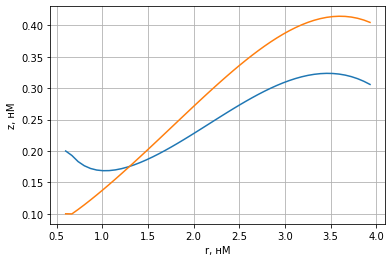

In [6]:
graph( out, ['n_u','n_d'], 1 )

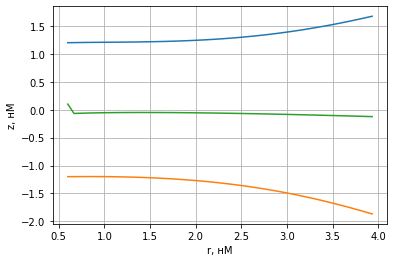

In [7]:
graph( out, ['H_u','H_d', 'M'], 1 )

In [ ]:
#save_grid( grid, number, left_values = None, right_values = None, energy = None )
save_grid( out, data_number, en, left_values, right_values)
# load_grid ( name, exceptions = 'numb' )